# Simple fit


In this example we consider the inversion problem of the mid-transit times for a three-planet system. 
We show the standard way for using nauyaca in order to estimate the planet masses and orbits. 
This is a synthetic planetary system whose transit ephemeris have been calculated as 
described in Canul et al. (2021). Unlike the two-planet system considered in the Documentation, here we exemplify the usage of the minimum code necessary to invert the problem. We obtain finally the MCMC posteriors and make a pair of figures to evaluate our results.

In [1]:
import nauyaca as nau
import matplotlib.pyplot as plt
import numpy as np

The input data is in the directory

In [2]:
directory = "./inputs/"

Defining planet objects: Names, boundaries and TTVs data

In [3]:
# Planet 1
P1 = nau.SetPlanet('Planet-b')
P1.mass = [0.001, 10]   # Explore super-Earth mass range
P1.period = [10.47, 10.48]
P1.ecc = [0.0, 0.1]
P1.inclination = [90,90]  # Constant!
P1.ascending_node = [60, 120]

P1.load_ttvs(directory + "3pl_planet1_ttvs.dat")

In [4]:
# Planet 2
P2 = nau.SetPlanet('Planet-c')
P2.mass = [0.001, 10]  
P2.period = [14.10, 14.11] 
P2.ecc = [0.0, 0.1]
P2.inclination = [85,95]
P2.ascending_node = [60, 120]

P2.load_ttvs(directory + "3pl_planet2_ttvs.dat")

In [5]:
# Planet 3
P3 = nau.SetPlanet('Planet-d')
P3.mass = [0.001, 10]  
P3.period = [23.57, 23.58]
P3.ecc = [0.0, 0.1]
P3.inclination = [90.3,90.3]  # Constant!
P3.ascending_node = [88.5, 88.5] # Constant!

P3.load_ttvs(directory + "3pl_planet3_ttvs.dat")

Creating the Planetary System object

In [6]:
PS = nau.PlanetarySystem("MySystem", mstar=0.522, rstar=0.4422)
PS.add_planets([P1, P2, P3])

# Print a summary of the Planetary System
print(PS)

--> Parameter -mass- of planet -Planet-b- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-b- set to lower physical limit: 1e-06
--> Parameter -mass- of planet -Planet-c- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-c- set to lower physical limit: 1e-06
--> Parameter -mass- of planet -Planet-d- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-d- set to lower physical limit: 1e-06

 =========== Planetary System Summary =========== 
--> Parameter -mass- of planet -Planet-b- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-b- set to lower physical limit: 1e-06
--> Parameter -mass- of planet -Planet-c- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-c- set to lower physical limit: 1e-06
--> Parameter -mass- of planet -Planet-d- set to lower physical limit: 0.0123032
--> Parameter -ecc- of planet -Planet-d- set to lower physical limit: 1e-06

Syste

From  the output above it is seen that the observations span around ~1360 days. Setting the simulation attribute ftime = 500 will discard all the observations greater than 500 days. It is useful when you want to quickly explore the possible solutions without evaluating all the transits, as in the case of this example. If not changed, these are the default simulations attributes calculated by nauyaca. Let's change the final time to exemplify the usage:

In [7]:
# Simulation attributes
# Here, t0 is the reference time of the osculating elements
PS.simulation(t0=0, ftime=500)

Save the Planetary System for further examples in json format

In [8]:
PS.save_json()

--> JSON file ./MySystem.json saved


### Running the optimizers. 

Let's run the optimizers to build an informed initial guess for the MCMC. Increase the number of solutions and specify an adequate number of cores to run in parallel.

In [9]:
optim = nau.Optimizers(PS, nsols=120, cores=8)

opt_solutions = optim.run()


 =========== OPTIMIZATION ===========

--> Starting date:  2021-08-16 15:17
--> Finding 120 solutions using 8 cores
--> Results will be saved at:
     * ./MySystem_cube.opt (normalized)
     * ./MySystem_phys.opt (physical)
--> Reference time of the solutions: 0 [days]
- - - - - - - - - - - - - - - - - - - - -
Solution  |   chi square from optimizers
- - - - - - - - - - - - - - - - - - - - -
 3 |  346729722.432  -->  624449.039  -->  373721.785
 7 |  304026464.383  -->  183995389.906  -->  140560.172
 2 |  314257803.181  -->  1002867.079  -->  108913.637
 1 |  213637841.023  -->  2065509.063  -->  158532.608
 4 |  418220204.410  -->  22166.197  -->  8928.114
 5 |  298811335.711  -->  2716081.077  -->  316567.898
 6 |  431389099.830  -->  122309874.901  -->  87801613.464
 8 |  889653777.894  -->  1281292.026  -->  19199.064
 13 |  158273363.622  -->  490365.607  -->  78315.261
 9 |  456897724.394  -->  370280.636  -->  140265.742
 14 |  397656483.107  -->  922399.208  -->  591199.157
 

### Running the MCMC. 

Here, we set the kwarg 'opt_data' with the optimizer results, but many other kwargs must be given in order to internally create initial walkers.

Try increasing the number of iterations, walkers or temperatures

In [11]:
mcmc = nau.MCMC(PS,
                tmax=100,          # Maximum temperature in ladder (see ptemcee documentation)
                itmax=12000,       # Maximum number of iterations      
                intra_steps=100,   # thinning factor
                cores=8,           # Cores to run in parallel
                opt_data=np.genfromtxt('MySystem_cube.opt') ,   # Solutions from optimizers (cube). 
                                                                # It can also be the variable -opt_solutions-
                distribution='Ladder',   # A strategy to initialize walkers
                fbest=0.05,         # A fraction of the best optimizer results
                nwalkers=60,       # Number of walkers
                ntemps=12          # Number of temperatures
                )
mcmc.run()


--> Selected distribution: Ladder
    6 of 120 solutions taken

 =========== PARALLEL-TEMPERING MCMC ===========

--> Starting date:  2021-08-16 20:21
--> Reference epoch of the solutions:  0  [JD]
--> Results will be saved at:  ./MySystem.hdf5
--> MCMC parameters:
      -ntemps: 12
      -nwalkers: 60
      -itmax: 12000
      -intra_steps: 100

--------- Iteration:  100
 Mean tau Temp 0: 0.828
 Accepted swap fraction in Temp 0:  0.049
 Mean acceptance fraction Temp 0:  0.243
 Mean log-likelihood:  -424.284
 Mean log-posterior:   -424.284
 Current log-posterior dispersion:  560.487
 Current MAP:  (0, 3) -211.424
 Saving time: 0.01350 sec
 Elapsed time:  0.4259 min
--------- Iteration:  200
 Mean tau Temp 0: 1.617
 Accepted swap fraction in Temp 0:  0.026
 Mean acceptance fraction Temp 0:  0.32
 Mean log-likelihood:  -90.842
 Mean log-posterior:   -90.842
 Current log-posterior dispersion:  98.647
 Current MAP:  (0, 5) -51.791
 Saving time: 0.01714 sec
 Elapsed time:  0.9258 min
-----

--------- Iteration:  2600
 Mean tau Temp 0: 18.346
 Accepted swap fraction in Temp 0:  0.002
 Mean acceptance fraction Temp 0:  0.26
 Mean log-likelihood:  571.2
 Mean log-posterior:   571.2
 Current log-posterior dispersion:  20.868
 Current MAP:  (0, 20) 583.114
 Saving time: 0.03046 sec
 Elapsed time:  12.2115 min
--------- Iteration:  2700
 Mean tau Temp 0: 18.982
 Accepted swap fraction in Temp 0:  0.002
 Mean acceptance fraction Temp 0:  0.256
 Mean log-likelihood:  572.138
 Mean log-posterior:   572.138
 Current log-posterior dispersion:  21.277
 Current MAP:  (0, 27) 586.148
 Saving time: 0.03131 sec
 Elapsed time:  12.6624 min
--------- Iteration:  2800
 Mean tau Temp 0: 19.613
 Accepted swap fraction in Temp 0:  0.002
 Mean acceptance fraction Temp 0:  0.253
 Mean log-likelihood:  574.228
 Mean log-posterior:   574.228
 Current log-posterior dispersion:  21.897
 Current MAP:  (0, 40) 590.158
 Saving time: 0.03253 sec
 Elapsed time:  13.1092 min
--------- Iteration:  2900
 Me

--------- Iteration:  5200
 Mean tau Temp 0: 31.926
 Accepted swap fraction in Temp 0:  0.009
 Mean acceptance fraction Temp 0:  0.191
 Mean log-likelihood:  587.918
 Mean log-posterior:   587.918
 Current log-posterior dispersion:  16.579
 Current MAP:  (0, 11) 600.401
 Saving time: 0.02902 sec
 Elapsed time:  23.9053 min
--------- Iteration:  5300
 Mean tau Temp 0: 32.182
 Accepted swap fraction in Temp 0:  0.009
 Mean acceptance fraction Temp 0:  0.189
 Mean log-likelihood:  589.301
 Mean log-posterior:   589.301
 Current log-posterior dispersion:  13.706
 Current MAP:  (0, 8) 600.306
 Saving time: 0.02986 sec
 Elapsed time:  24.353 min
--------- Iteration:  5400
 Mean tau Temp 0: 32.397
 Accepted swap fraction in Temp 0:  0.01
 Mean acceptance fraction Temp 0:  0.188
 Mean log-likelihood:  588.664
 Mean log-posterior:   588.664
 Current log-posterior dispersion:  15.006
 Current MAP:  (0, 8) 600.37
 Saving time: 0.03068 sec
 Elapsed time:  24.8017 min
--------- Iteration:  5500
 Me

--------- Iteration:  7800
 Mean tau Temp 0: 26.535
 Accepted swap fraction in Temp 0:  0.023
 Mean acceptance fraction Temp 0:  0.158
 Mean log-likelihood:  593.017
 Mean log-posterior:   593.017
 Current log-posterior dispersion:  10.49
 Current MAP:  (0, 50) 602.032
 Saving time: 0.02751 sec
 Elapsed time:  35.5018 min
--------- Iteration:  7900
 Mean tau Temp 0: 25.979
 Accepted swap fraction in Temp 0:  0.024
 Mean acceptance fraction Temp 0:  0.157
 Mean log-likelihood:  589.74
 Mean log-posterior:   589.74
 Current log-posterior dispersion:  15.577
 Current MAP:  (0, 6) 602.786
 Saving time: 0.02764 sec
 Elapsed time:  35.9426 min
--------- Iteration:  8000
 Mean tau Temp 0: 25.436
 Accepted swap fraction in Temp 0:  0.025
 Mean acceptance fraction Temp 0:  0.156
 Mean log-likelihood:  592.189
 Mean log-posterior:   592.189
 Current log-posterior dispersion:  12.297
 Current MAP:  (0, 0) 601.927
 Saving time: 0.02883 sec
 Elapsed time:  36.3792 min
--------- Iteration:  8100
 Me

--------- Iteration:  10400
 Mean tau Temp 0: 10.59
 Accepted swap fraction in Temp 0:  0.05
 Mean acceptance fraction Temp 0:  0.137
 Mean log-likelihood:  593.359
 Mean log-posterior:   593.359
 Current log-posterior dispersion:  9.266
 Current MAP:  (0, 53) 603.288
 Saving time: 0.02558 sec
 Elapsed time:  46.7459 min
--------- Iteration:  10500
 Mean tau Temp 0: 9.946
 Accepted swap fraction in Temp 0:  0.051
 Mean acceptance fraction Temp 0:  0.136
 Mean log-likelihood:  592.585
 Mean log-posterior:   592.585
 Current log-posterior dispersion:  10.788
 Current MAP:  (0, 14) 601.746
 Saving time: 0.02638 sec
 Elapsed time:  47.1813 min
--------- Iteration:  10600
 Mean tau Temp 0: 9.303
 Accepted swap fraction in Temp 0:  0.052
 Mean acceptance fraction Temp 0:  0.135
 Mean log-likelihood:  593.065
 Mean log-posterior:   593.065
 Current log-posterior dispersion:  9.159
 Current MAP:  (0, 6) 601.404
 Saving time: 0.02734 sec
 Elapsed time:  47.6251 min
--------- Iteration:  10700
 

Print a summary of the results and get a dictionary with the posteriors. Let's make first a burnin of the first 20% of the chains. This burnin will be applied over the posteriors.

In [12]:
burn = 0.2

In [13]:
posteriors = nau.utils.mcmc_summary(PS, 
                        hdf5_file=mcmc.hdf5_filename,
                        burnin=burn,
                        get_posteriors=True)

--> Planetary System:  MySystem
    Stellar mass:  0.522
    Stellar radius:  0.4422
    Number of planets:  3
--> Planets:
       Planet 1: Planet-b
       Planet 2: Planet-c
       Planet 3: Planet-d
    
--------------------------
--> MCMC parameters
    Ntemps:  12
    Nwalkers per temperature:  60
    Number of iterations:  12000
    Thining:  100
    Burnin:  0.2
    Chain shape:  (60, 97, 18)
--------------------------
      RESULTS             
--> Results in File:   ./MySystem.hdf5
--> Reference epoch of the solutions:  0  [JD]
--> Best solution in MCMC
      Logl:  603.37856
               mass period ecc inclination argument mean_anomaly ascending_node
      Planet 1: 0.0738   10.4708   0.0431   90.0   256.1075   285.7213   100.8759
      Planet 2: 2.1322   14.105   0.0419   91.1692   216.4375   217.1319   102.3262
      Planet 3: 0.7461   23.5749   0.0191   90.3   355.4471   234.6966   88.5
--------------------------
--> MCMC medians and 1-sigma errors
             mass1   

Plot a pair of results. Let's show the masses space for these three planets, where the colors are related to the iterations progress


Available posteriors are:
['mass1', 'period1', 'ecc1', 'argument1', 'mean_anomaly1', 'ascending_node1', 'mass2', 'period2', 'ecc2', 'inclination2', 'argument2', 'mean_anomaly2', 'ascending_node2', 'mass3', 'period3', 'ecc3', 'argument3', 'mean_anomaly3']



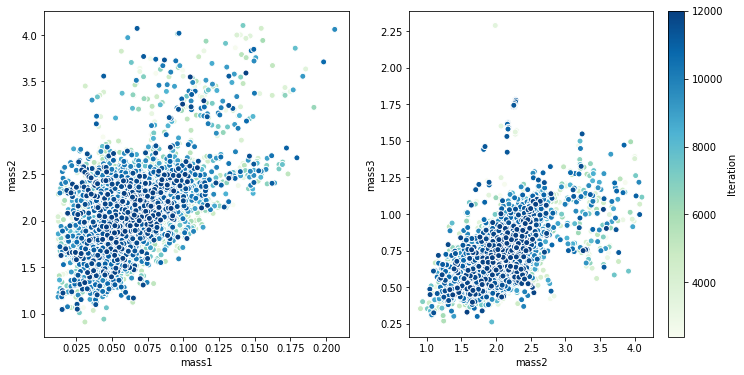

In [14]:
# See the available keys in posteriors
print("\nAvailable posteriors are:")
print(list(posteriors.keys()))
print()

post1 = 'mass1'
post2 = 'mass2'
post3 = 'mass3'

# Colors show the movement forward
lburn = mcmc.itmax*burn
nsave = int(len(posteriors[post1])/mcmc.nwalkers)
steps = np.array([[lburn+(i*mcmc.intra_steps)]*mcmc.nwalkers for i in range(nsave)]).flatten()

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].scatter(posteriors[post1], posteriors[post2],c=steps, 
                edgecolor='w',cmap='GnBu')
axes[0].set_xlabel(post1)
axes[0].set_ylabel(post2)

im=axes[1].scatter(posteriors[post2], posteriors[post3],c=steps, 
                   edgecolor='w',cmap='GnBu')
axes[1].set_xlabel(post2)
axes[1].set_ylabel(post3)
plt.colorbar(im).set_label('Iteration')

plt.savefig(f'3pl_{post1}_{post2}_{post3}.jpg')

Plot a pair of built-in figures from the nauyaca's Plots module. -burnin- will discard the first 20% of the initial chains

In [15]:
nauplot = nau.Plots(PS, hdf5_file=mcmc.hdf5_filename, burnin=burn, temperature=0)

--> plotting random solutions


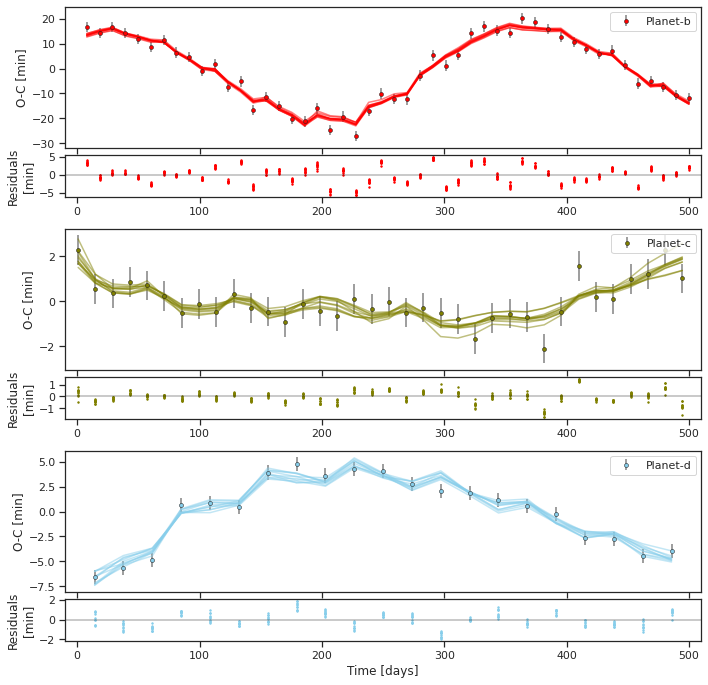

In [16]:
# Plot the fitted TTVs
nauplot.TTVs(nsols=10, 
             mode='random'  # 'best'
            );

plt.savefig('3pl_TTVs.jpg')

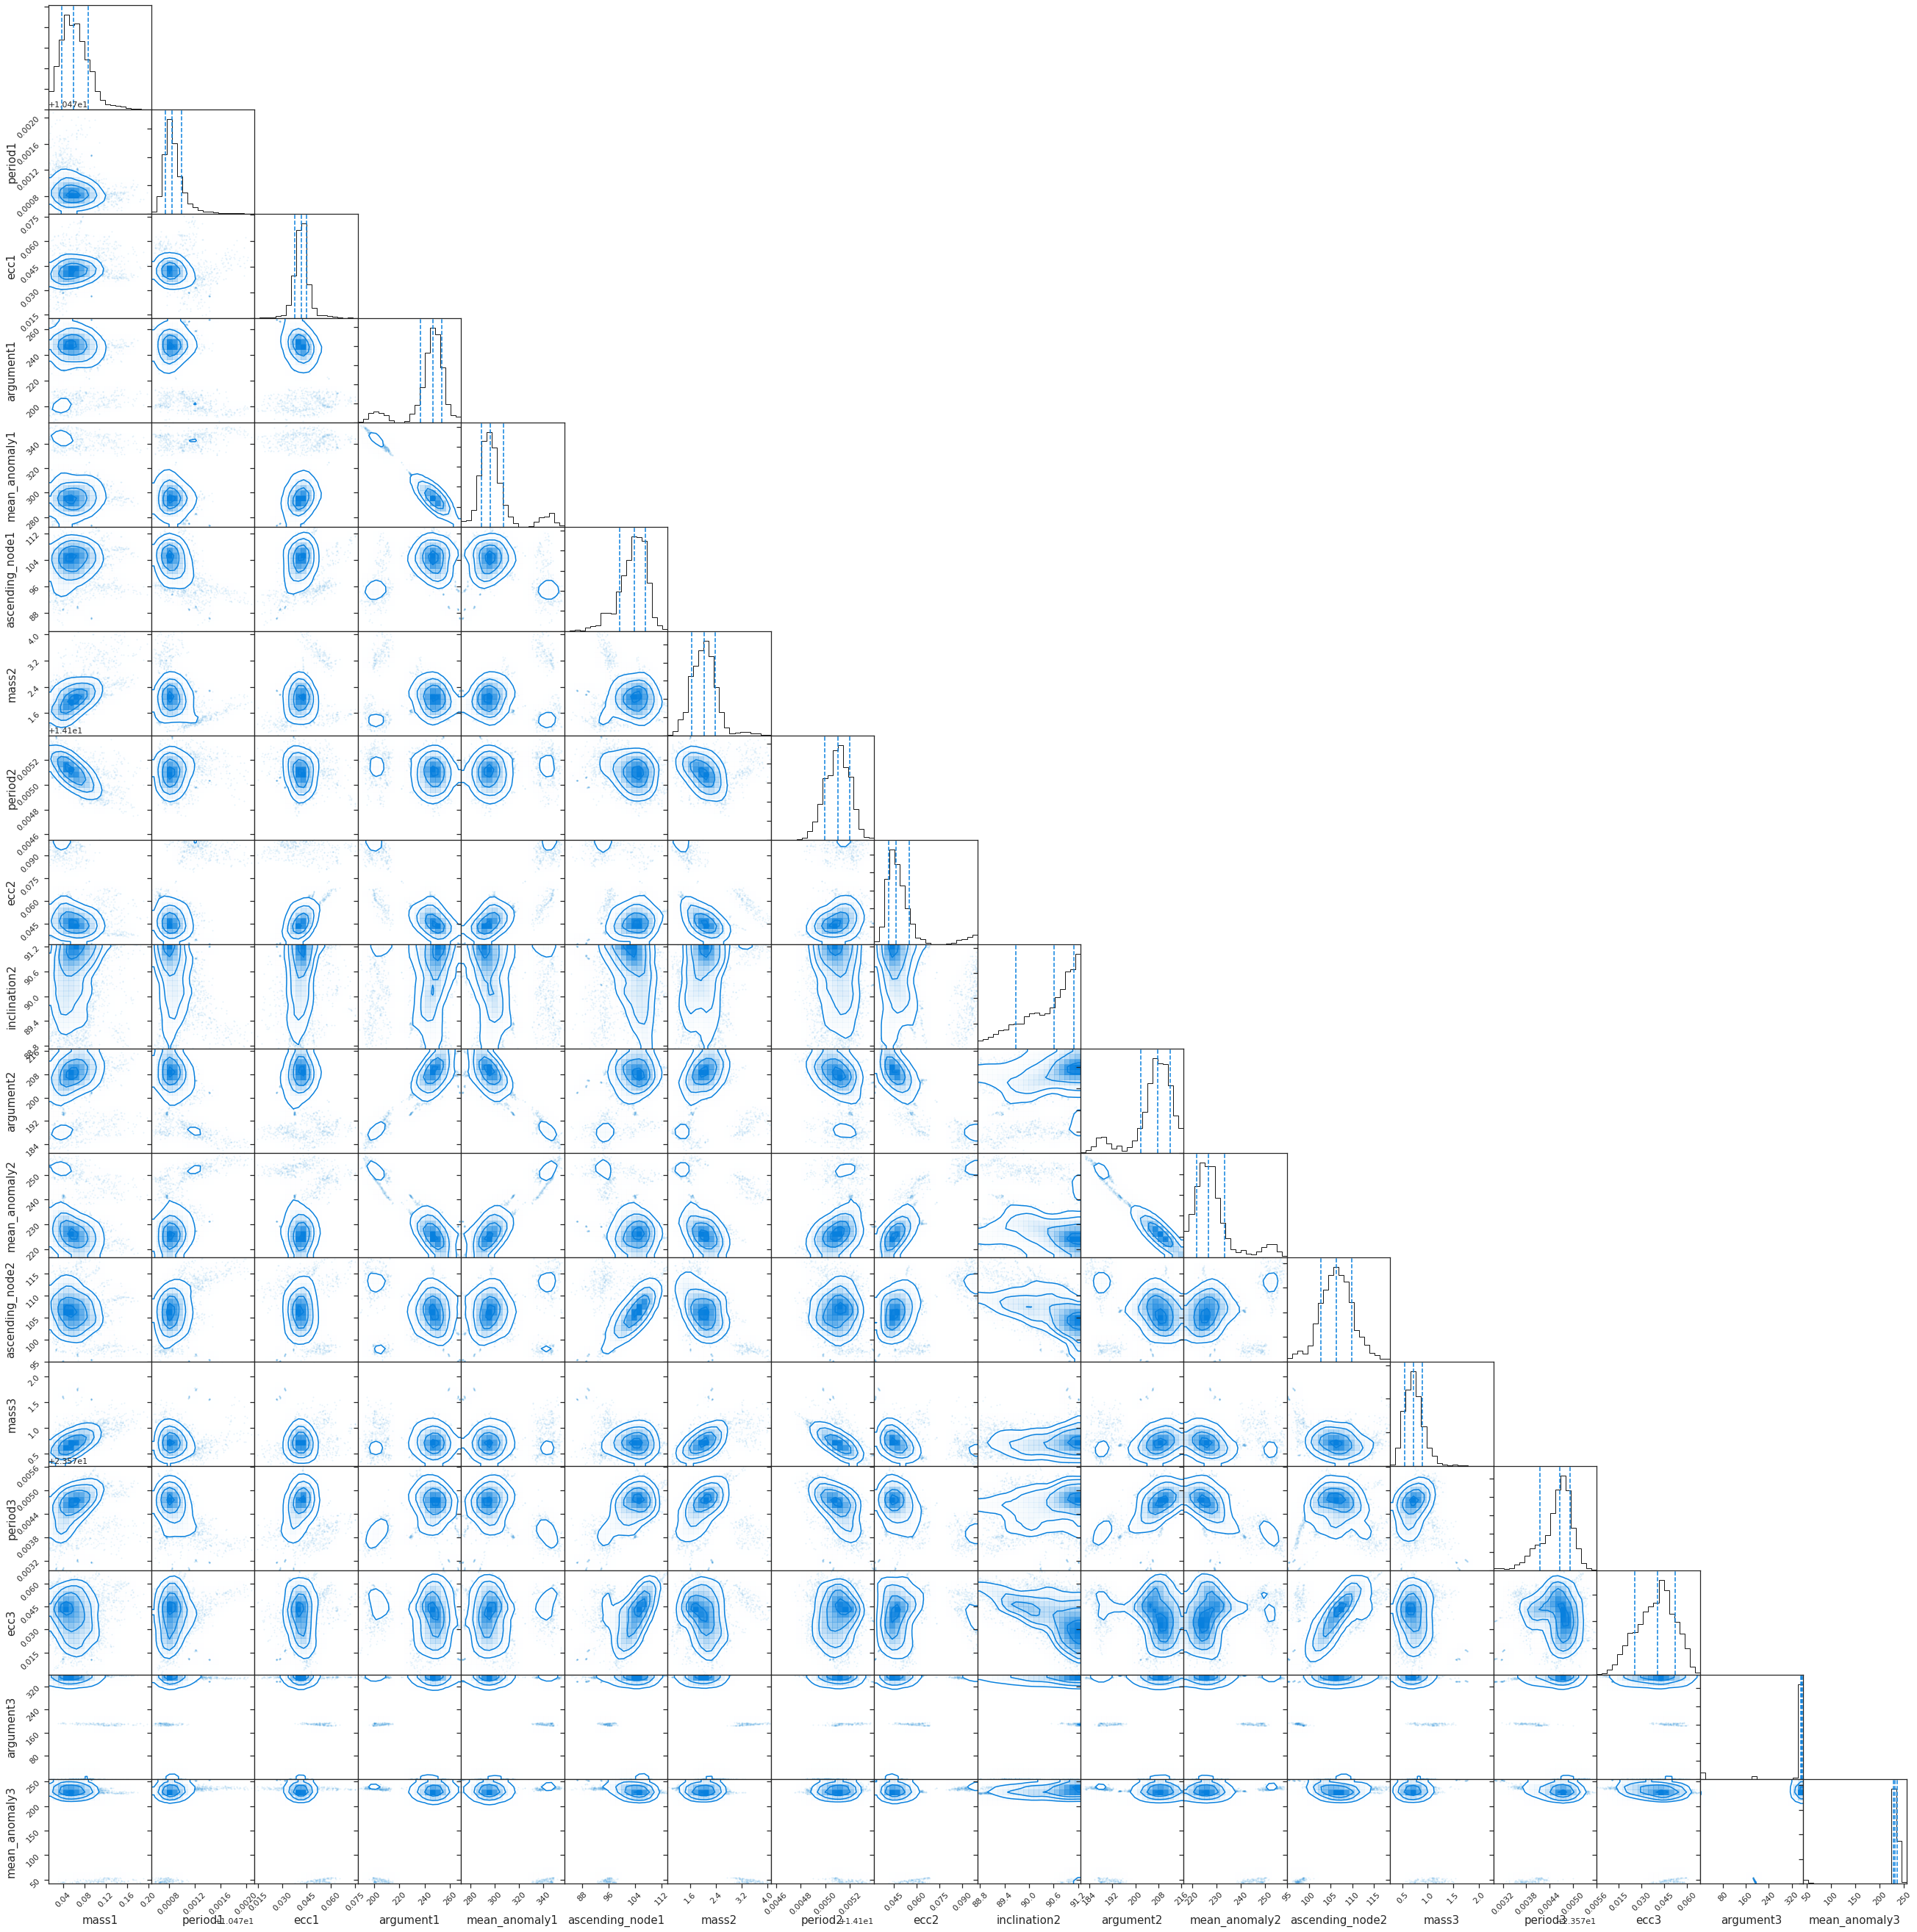

In [17]:
# Plot a croner plot
nauplot.corner_plot();

plt.savefig('3pl_corner.jpg')

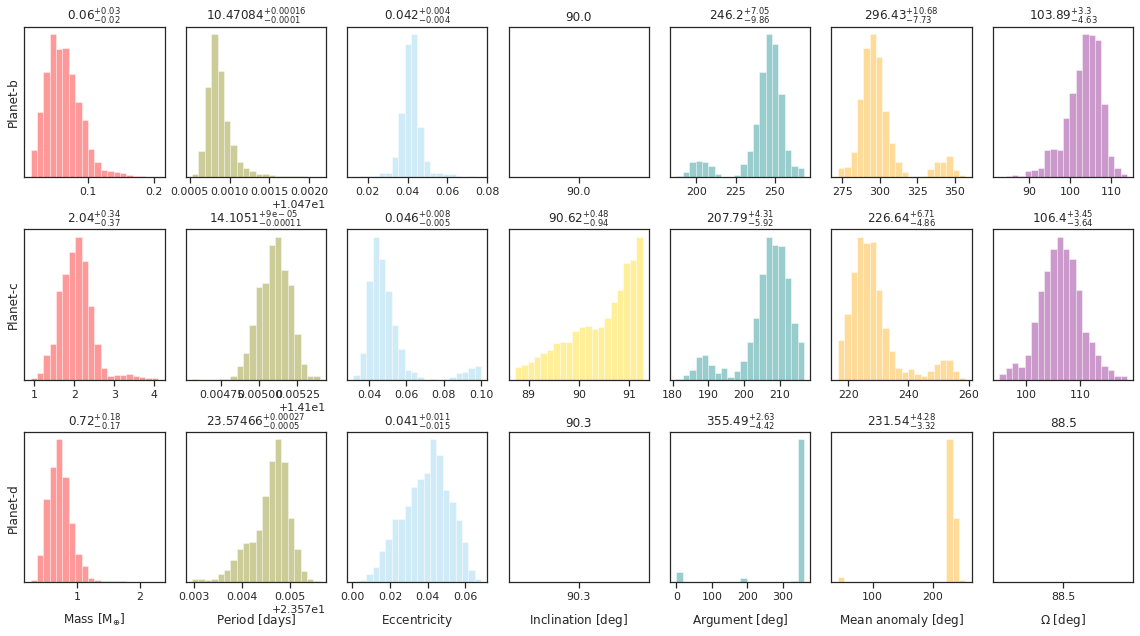

In [18]:
# Plot histograms of the posteriors
nauplot.hist(titles=True);

plt.savefig('3pl_hist.jpg')

Compare your results! The true planetary parameters for this synthetic system are stored in './inputs/trues':

    Planet mass period ecc inc argument mean_anomaly asc_node

    1    0.07652, 10.4707, 0.0406, 89.809, 292.62, 246.14, 88.3,

    2    1.98033, 14.10509, 0.0244, 89.909, 239.76, 191.31, 88.46,

    3    0.6705, 23.57467, 0.0306, 90.336, 82.64, 149.24, 88.51

In example 'restarting_mcmc' we'll see how to restart the mcmc to make more iterations and improve the results.

_________________________

# Quitar todo lo que sigue

In [53]:
nauplot.temperature=10

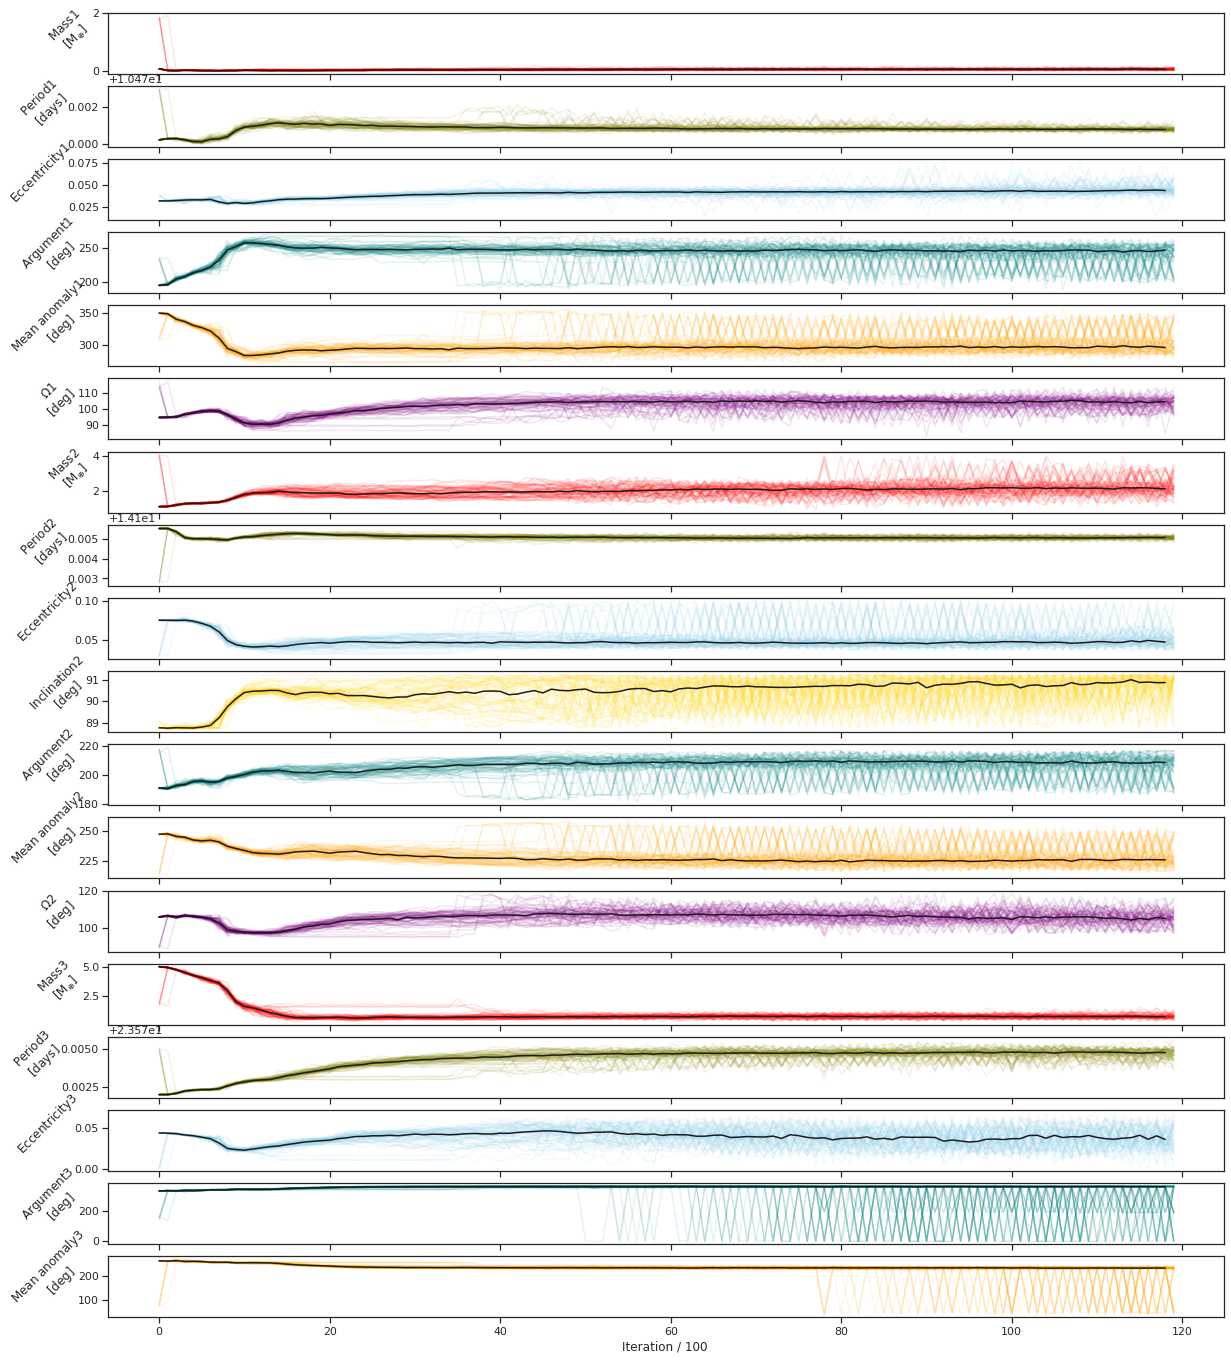

In [19]:
nauplot.trace_plot(plot_means=True);

--> Performing Gelman-Rubin test
--> Performing Geweke test


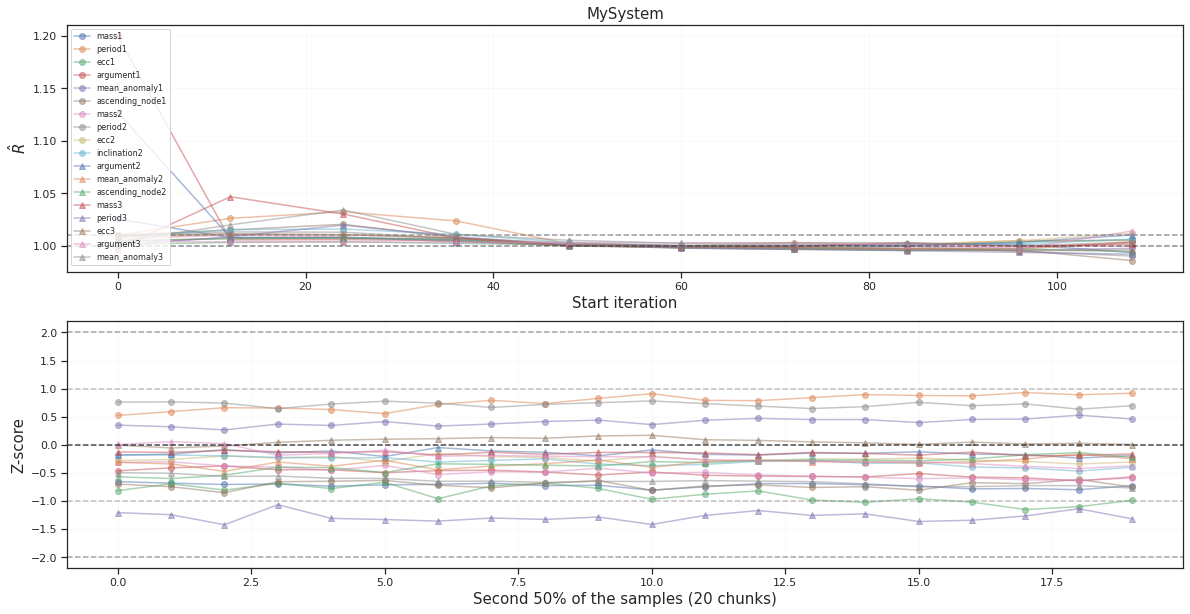

In [20]:
nauplot.convergence();

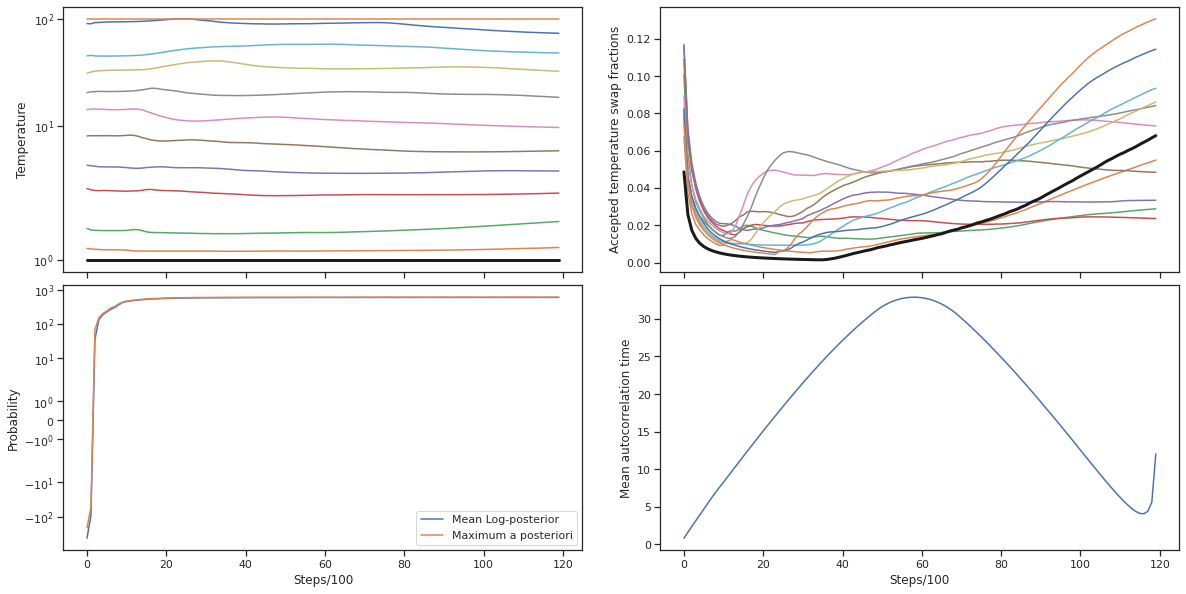

In [21]:
nauplot.monitor();

___________________